In [443]:
#### libraries
import numpy as np
# np.seterr(all='raise') # raise errors, don't just print warnings
from numpy import *
from numpy.linalg import eig
from numpy.random import normal
from scipy.optimize import curve_fit, least_squares
from random import random as rand



#### local files
from utilities.physconsts import *
from utilities.rbconsts import *
from utilities.rbensemble import RbEnsemble as ensemble
from matplotlib import pyplot as plt



In [ ]:
# a test with 50 uK atoms
factor = 1
w0 = 2.5e-6 * factor # [m]
TFORT = 1.5e-3 * factor # [K]
Tatom = 5e-5 #* factor# [K]
steps = 10
tlist = linspace(0,160,steps) # time [us
lmda = 1.064e-6 * factor
wx = w0
wy = wx


umax = kB*TFORT #times factor

zR = pi*wx**2/lmda
zRFactor = factor

omega_r = (1/sqrt((wx**2+wy**2)/2))*sqrt(2*kB*TFORT/mRb) # radial trap frequency

omega_z = (1/zR)*sqrt(2*kB*TFORT/mRb) # axial trap frequency

omega_r_unfactored = omega_r*sqrt(factor)
print(omega_z, omega_z*sqrt(factor))
# ww = lambda z: (1+z**2/zR**2)
# U = lambda x, y, z: -umax*exp(-2*x**2/(wx**2*ww(z))-2*y**2/(wy**2*ww(z)))/ww(z) 
event_ct = 200000


In [691]:
def U(x,y,z):
    ww = (1+z**2/zR**2)
    return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww

In [692]:
def xdist(T, events,plane=None):
        T *= 1e-6
        """ position component distributions """
        # Grainger group method
        omega_r
        omega_z
        
        dx = dy = sqrt(kB*T/(mRb*omega_r**2))
        dx
        dz = sqrt(kB*T/(mRb*omega_z**2))
        zlist = normal(0,dz,size=events)
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)
        # print(xlist)
        if plane == 'xz':
            return xlist,zlist
        else:
            return xlist,ylist,zlist

In [568]:
U(*xdist(50,2000))

array([-1.89406502e-26, -1.90832908e-26, -1.88342745e-26, ...,
       -2.04618604e-26, -1.71606201e-26, -1.97216434e-26])

In [569]:
 def vdist(T, events):
        """ maxwell boltzmann speeds """
        atoms = ensemble(T)
        T *= 1e-6
        vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds

        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
        
        for i in range(events):
            ex = 2*rand()-1
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A
            
#         vlist = array([sqrt(vx**2+vy**2+vx**2) for vx,vy,vz in zip(vxlist,vylist,vzlist)])
#         plt.hist(vlist, 50, density=True) # show maxwell boltzmann speed dist
#         plt.xlabel('v')
#         plt.ylabel('occurences')
#         plt.show()

        return vxlist,vylist,vzlist



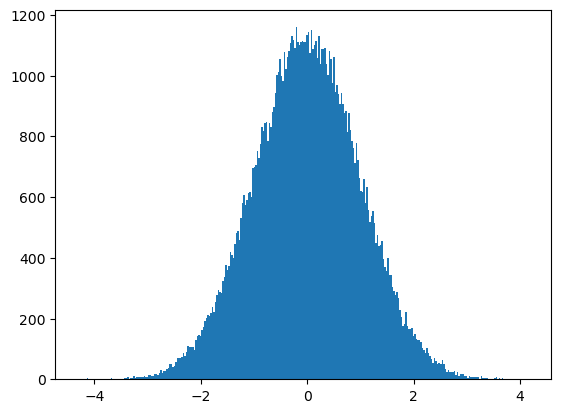

[ 1.12878418e+01 -1.89981923e-02  1.99917287e+00 -2.12095093e-03]


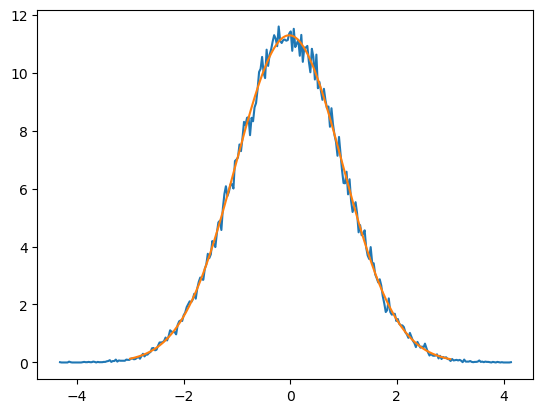

In [926]:
init_guess = (100,30,10,33000)

upper_bounds = [10000,40,100,40000]
lower_bounds = [100,5,2,10000]

def model(x, a, x0, w0, b):
    return a*np.exp(-2*((x-x0)/w0)**2) + b

xdata = np.linspace(-3, 3,100000)
ydata = normal(size = len(xdata))
count, bins, ignored = plt.hist(ydata, bins = 300)
plt.show()
count/=100
bins = bins[0:300]
plt.plot(bins,count)
popt,pcov = curve_fit(model,bins,count)

print(popt)
plt.plot(xdata,model(xdata,*popt))

In [693]:
def distplot(T,events, atoms=True, sx=1.5, sz=1.5, color="bone"):
        """ show atoms in FORT in z = 0 plane before drop and recapture """
        mu = 1e-6
        print(f"zr={zR/mu:.0f} [um], wx={wx/mu:.0f} [um]")
        
        xlist,ylist = xdist(T=T,events=events,plane='xz') # positions in [m]
        
        xpts = linspace(-sx*wx,sx*wx,100)
        zpts = linspace(-sz*zR,sz*zR,100)
        xx,zz = meshgrid(xpts,zpts)
        fpts = -U(xx,0,zz) # the fort intensity eval'd on the meshgrid
        
        cmap = plt.cm.get_cmap(color)
        
        plt.contourf(xpts/mu,zpts/mu,fpts, cmap=cmap)
        if atoms is True: # otherwise, just a dipole trap plot  
            plt.scatter(xlist/mu,ylist/mu,color='red')
        plt.xlabel("x")
        plt.ylabel("z")
#         plt.axes().set_aspect('equal')
        plt.show() 


In [1130]:
def drop_recap(tlist,T=None,events=None,base_retention=None, Tdepth = None,
            progress=False, b = 1, c = 0):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment. 
        
            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT 
        """
        zR = pi*wx**2/lmda
        
        tlist = 1e-6*tlist
    
        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1 # the retention baseline with no fort drop

        retention = empty(len(tlist))
        
        xlist,ylist,zlist = xdist(T,events)
        vzlist,vxlist,vylist = vdist(T,events)
        #print(xlist)
        g_scaled = g*1e3
        for j,t in enumerate(tlist):

            escape = 0 
            nhot = 0 # this is an untrapped atom
            
            for i in range(events):     
                hot = 0
                KE = .5*mRb*((vxlist[i]-g*t)**2+vylist[i]**2
                              +vzlist[i]**2)
                PE0 = U(xlist[i],ylist[i],zlist[i])
                PE = U(xlist[i]+t*vxlist[i]+.5*g*(t)**2,
                       ylist[i]+t*vylist[i],
                       zlist[i]+t*vzlist[i])

                if KE + PE0 > 0:
                    hot = 1
                nhot += hot
                if KE + PE > 0:
                    escape += 1-hot
            retention[j] = base_retention*(1 - escape/events)
            
            if progress is not False:
                if j % 10 == 0:
                    print(f"timestep {j}: t = {t*1e6:.0f} [us], ret = {retention[j]:.2f}")

        retention = (retention*b - c)
        tlist*=1e6
        plt.plot(tlist,retention,label=f'{T/1e-6:.0f} uK') # show time in units [us]
#         plt.xlabel("time [us]")
#         plt.ylabel("retention")
#         plt.ylim((0,1))
#         plt.legend()
#         plt.show()        

        
        print(f"finished. T={T*1e6} [uK], r = {base_retention}")
        return tlist, retention

In [1131]:
def retention_at_t_2(t, T=None, events=None, base_retention=None,
                   progress=False, t_target = 0, Tdepth = None,lmda = None, wx = None, wy = None ):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment.

            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT
        """
        if wy is None:
            wy = wx
        
        umax = kB*Tdepth
        zR = pi*wx**2/lmda
        
        omega_r = (1/sqrt((wx**2+wy**2)/2))*sqrt(2*kB*TFORT/mRb) # radial trap frequency

        omega_z = (1/zR)*sqrt(2*kB*TFORT/mRb) # axial trap frequency

        
        # Tdepth = Tdepth
        def U(x,y,z):
            ww = (1+z**2/zR**2)
            return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww
            
        
        dx = dy = sqrt(kB*T/(mRb*omega_r**2))
        dx
        dz = sqrt(kB*T/(mRb*omega_z**2))            
        zlist = normal(0,dz,size=events)        
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)


        atoms = ensemble(T)
            
        vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds
    
        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
            
        for i in range(events):
            ex = 2*rand()-1                
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A
            #print(f"A:{i}::",A)
        
        
    
        # t = t*1e-6

        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1  # the retention baseline with no fort drop
        

        #xlist, ylist, zlist = xdist(T,events)
        #vzlist, vxlist, vylist = vdist(T,events)
        # print(xlist)
        escape = 0
        nhot = 0  # this is an untrapped atom

        for i in range(events):
            hot = 0
            KE = .5 * mRb * ((vxlist[i] - g * t) ** 2 + vylist[i] ** 2
                             + vzlist[i] ** 2)
            PE0 = U(xlist[i], ylist[i], zlist[i])
            PE = U(xlist[i] + t * vxlist[i] + .5 * g * (t) ** 2,
                        ylist[i] + t * vylist[i],
                        zlist[i] + t * vzlist[i])

            
            # print(f"t = {t}")

            hot = 1*(KE + PE0 > 0)
            nhot += hot
            escape = (1 - hot)*(KE + PE > 0)

        retention = base_retention * (1 - escape / events)




        

        print(f"finished. T={T * 1e6} [uK], r = {base_retention}")
        return retention



In [1174]:
def retention_at_t_3(t, T=None,base_retention=0.9, b = 1, c = 0):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment.

            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT
        """
        T = abs(T)
        events = 20000
        factor = 1
        w0 = 2.5e-6 * factor # [m]
        Tdepth = 1.5e-3 * factor # [K]
        Tatom = 5e-5 #* factor# [K]
        steps = 10
        lmda = 1.064e-6 * factor
        wx = w0
        wy = wx
        
        
        umax = kB*Tdepth
        zR = pi*wx**2/lmda
        
        omega_r = (1/sqrt((wx**2+wy**2)/2))*sqrt(2*kB*TFORT/mRb) # radial trap frequency

        omega_z = (1/zR)*sqrt(2*kB*TFORT/mRb) # axial trap frequency

        
    
        
        # Tdepth = Tdepth
        def U(x,y,z):
            ww = (1+z**2/zR**2)
            return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww
            
        
        dx = dy = sqrt(kB*T/(mRb*omega_r**2))
        dx
        dz = sqrt(kB*T/(mRb*omega_z**2))            
        zlist = normal(0,dz,size=events)        
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)


        atoms = ensemble(T)
            
        vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds
    
        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
            
        for i in range(events):
            ex = 2*rand()-1                
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A
            #print(f"A:{i}::",A)
        
        
    
        t = t*1e-6

        if events is None:
            events = 20000
        if base_retention is None:
            base_retention = 1  # the retention baseline with no fort drop
        

        #xlist, ylist, zlist = xdist(T,events)
        #vzlist, vxlist, vylist = vdist(T,events)
        #print(xlist)
        escape = np.float64(np.empty(len(t)))
        nhot = 0  # this is an untrapped atom

        for i in range(events):
            hot = 0
            KE = .5 * mRb * ((vxlist[i] - g * t) ** 2 + vylist[i] ** 2
                             + vzlist[i] ** 2)
            PE0 = U(xlist[i], ylist[i], zlist[i])
            PE = U(xlist[i] + t * vxlist[i] + .5 * g * (t) ** 2,
                        ylist[i] + t * vylist[i],
                        zlist[i] + t * vzlist[i])

            
            #print(f"t = {t}")
            
            
            init_E = KE + PE0
            hot_E = KE + PE
            
            escape+=(np.float64((np.greater(hot_E,0))))
                
        retention = base_retention * (1 - escape / np.float64(events))




        

        print(f"finished. T={T * 1e6} [uK], r = {base_retention}, b = {b}, c = {c}")
        #print(b,c,retention,t)
        return b*retention-c



In [ ]:
TLIST = linspace(0,120,10) # time [us]
R1 = retention_at_t_3(TLIST, 5e-5, base_retention = 0.9)
print(R1)

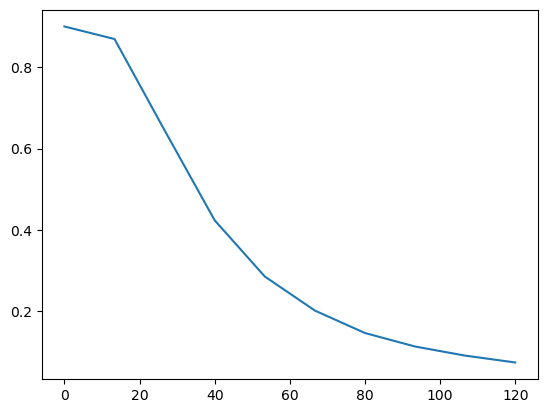

In [1138]:
plt.plot(TLIST,R1)

In [1083]:
def retention_at_t(t, T=None, events=None, base_retention=None,
                   progress=False, Tdepth = None,):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment.

            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT
        """
        
        # Tdepth = Tdepth
        def U(x,y,z):
            ww = (1+z**2/zR**2)
            return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww
        def xdist(T, events,plane=None):
            """ position component distributions """
            # Grainger group method
            omega_r
            omega_z
            
            dx = dy = sqrt(kB*T/(mRb*omega_r**2))
            dx
            dz = sqrt(kB*T/(mRb*omega_z**2))
            zlist = normal(0,dz,size=events)
            xlist = normal(0,dx,size=events)
            ylist = normal(0,dy,size=events)
            # print(xlist)
            if plane == 'xz':
                return xlist,zlist
            else:
                return xlist,ylist,zlist
        
        def vdist(T, events):
            """ maxwell boltzmann speeds """
            #atoms = ensemble(T)
            
            #vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds
    
            vxlist = empty(events)
            vylist = empty(events)
            vzlist = empty(events)
            
            for i in range(events):
                ex = 2*rand()-1
                ey = 2*rand()-1
                ez = 2*rand()-1
                v = vlist[i]
                A = sqrt(ex**2+ey**2+ez**2)
                vxlist[i] = ex*v/A
                vylist[i] = ey*v/A
                vzlist[i] = ez*v/A
                
    #         vlist = array([sqrt(vx**2+vy**2+vx**2) for vx,vy,vz in zip(vxlist,vylist,vzlist)])
    #         plt.hist(vlist, 50, density=True) # show maxwell boltzmann speed dist
    #         plt.xlabel('v')
    #         plt.ylabel('occurences')
    #         plt.show()

            return vxlist,vylist,vzlist
    
        t = t*1e-6

        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1  # the retention baseline with no fort drop
        

        xlist, ylist, zlist = xdist(T,events)
        vzlist, vxlist, vylist = vdist(T,events)
        # print(xlist)
        escape = 0
        nhot = 0  # this is an untrapped atom

        for i in range(events):
            hot = 0
            KE = .5 * mRb * ((vxlist[i] - g * t) ** 2 + vylist[i] ** 2
                             + vzlist[i] ** 2)
            PE0 = U(xlist[i], ylist[i], zlist[i])
            PE = U(xlist[i] + t * vxlist[i] + .5 * g * (t) ** 2,
                        ylist[i] + t * vylist[i],
                        zlist[i] + t * vzlist[i])

            
            # print(f"t = {t}")

            hot = 1*(KE + PE0 > 0)
            nhot += hot
            escape = (1 - hot)*(KE + PE > 0)

        retention = base_retention * (1 - escape / events)        

        print(f"finished. T={T * 1e6} [uK], r = {base_retention}")
        return retention

In [1084]:
def run_drop(tlist, Tatom):
    rlist = retention_at_t(tlist, T=Tatom, base_retention=0.9, Tdepth = TFORT, events = event_ct)
    #rlist = drop_recap(tlist, T=Tatom, base_retention = 0.9)
    return np.log(rlist)

In [1056]:
def run_drop_3(tlist, Tatom, base_retention):
    # print(Tatom)
    rlist = retention_at_t_2(tlist, T=Tatom, base_retention=base_retention, Tdepth = TFORT, events = event_ct, wx = wx, lmda = lmda,)
    #rlist = drop_recap(tlist, T=Tatom, base_retention = 0.9)
    return rlist


In [1057]:
def run_drop_2(t,Tatom, wx1, Tdepth1):
    rlist = retention_at_t_2(t, T=Tatom, events=event_ct, base_retention=0.9,
                   progress=True, Tdepth = Tdepth1,lmda = lmda, wx = wx1, wy = None )
    return rlist
def run_drop_4(t,Tatom, wx1, Tdepth1, base_retention):
    rlist = retention_at_t_2(t, T=Tatom, events=event_ct, base_retention=base_retention,
                   progress=True, Tdepth = Tdepth1,lmda = lmda, wx = wx1, wy = None )
    return rlist

In [1058]:
def run_drop_log_params(x, log_T_0,):
    """
    Model for Bcd gradient: exponential decay plus 
    background with log parameters.
    """
    
    # Exponentiate parameters
    T_0 = np.exp(log_T_0)
    
    return run_drop(x, T_0)
    

In [1064]:
Tatom = 5e-5


5e-05
1.3807e-23
5e-05
1.4192261e-25
1
finished. T=50.0 [uK], r = 0.9


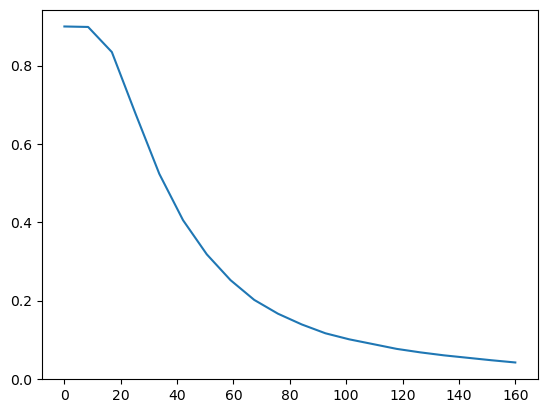

In [1181]:
#distplot(Tatom, events = event_ct)
tlist = linspace(0,160,20) # time [us]
TLIST = linspace(0,160,20) # time [us]
tlist, r1 = drop_recap(tlist, 5e-5, base_retention = 0.9, events = 20000)

5e-05
1.3807e-23
5e-05
1.4192261e-25
1
finished. T=50.0 [uK], r = 0.9, b = 1, c = 0


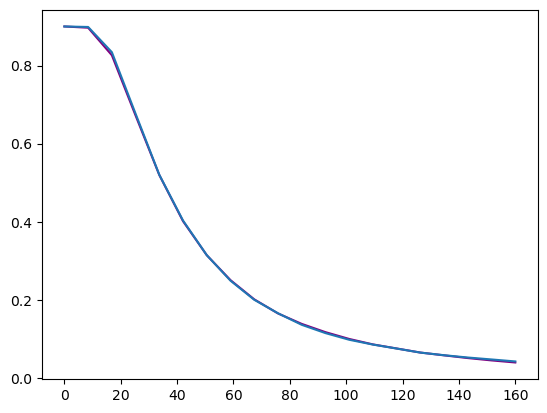

In [1140]:
R1 = retention_at_t_3(TLIST, 5e-5, base_retention = 0.9)
plt.plot(TLIST,R1, color = "purple")
plt.plot(tlist,r1)

In [ ]:
print((tlist))

In [1182]:
t_data = array([0.0, 2.0, 4.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 
                20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0])
ret_data = [0.92079207920792083, 0.94999999999999996, 0.93000000000000005, 
            0.89000000000000001, 0.93999999999999995, 0.90000000000000002, 
            0.93999999999999995, 0.84999999999999998, 0.85999999999999999, 
            0.81000000000000005, 0.67000000000000004, 0.39000000000000001, 
            0.28712871287128711, 0.27000000000000002, 0.16, 0.10000000000000001, 
            0.089999999999999997]
factor = 1
lower_bound = [1e-5*factor]
upper_bound = [9e-5*factor]


popt, pcov, infodict, msg, ier = curve_fit(retention_at_t_3, TLIST, R1, p0 = [4e-5], absolute_sigma=False, maxfev = 1000000000, full_output = True,epsfcn = 1)



4e-05
1.3807e-23
4e-05
1.4192261e-25
1
finished. T=40.0 [uK], r = 0.9, b = 1, c = 0
8e-05
1.3807e-23
8e-05
1.4192261e-25
1
finished. T=80.0 [uK], r = 0.9, b = 1, c = 0
5.422999200879436e-05
1.3807e-23
5.422999200879436e-05
1.4192261e-25
1
finished. T=54.22999200879436 [uK], r = 0.9, b = 1, c = 0
0.00010845998401758873
1.3807e-23
0.00010845998401758873
1.4192261e-25
1
finished. T=108.45998401758872 [uK], r = 0.9, b = 1, c = 0
4.847637261498416e-05
1.3807e-23
4.847637261498416e-05
1.4192261e-25
1
finished. T=48.47637261498416 [uK], r = 0.9, b = 1, c = 0
9.695274522996831e-05
1.3807e-23
9.695274522996831e-05
1.4192261e-25
1
finished. T=96.95274522996831 [uK], r = 0.9, b = 1, c = 0
5.146891585230176e-05
1.3807e-23
5.146891585230176e-05
1.4192261e-25
1
finished. T=51.46891585230176 [uK], r = 0.9, b = 1, c = 0
0.00010293783170460352
1.3807e-23
0.00010293783170460352
1.4192261e-25
1
finished. T=102.93783170460352 [uK], r = 0.9, b = 1, c = 0
5.0635187497901285e-05
1.3807e-23
5.0635187497901285

In [1187]:
t_data = array([0.0, 2.0, 4.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 
                20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0])
ret_data = [0.92079207920792083, 0.94999999999999996, 0.93000000000000005, 
            0.89000000000000001, 0.93999999999999995, 0.90000000000000002, 
            0.93999999999999995, 0.84999999999999998, 0.85999999999999999, 
            0.81000000000000005, 0.67000000000000004, 0.39000000000000001, 
            0.28712871287128711, 0.27000000000000002, 0.16, 0.10000000000000001, 
            0.089999999999999997]
R1 = retention_at_t_3(TLIST, 5e-5, base_retention = 0.9)
factor = 1
lower_bound = [1e-5*factor]
upper_bound = [9e-5*factor]


popt, pcov, infodict, msg, ier = curve_fit(retention_at_t_3, TLIST, R1, p0 = [4e-5, 0.88], absolute_sigma=False, maxfev = 1000000000, full_output = True,epsfcn = 1)



4e-05
1.3807e-23
4e-05
1.4192261e-25
1
finished. T=40.0 [uK], r = 0.88, b = 1, c = 0
8e-05
1.3807e-23
8e-05
1.4192261e-25
1
finished. T=80.0 [uK], r = 0.88, b = 1, c = 0
4e-05
1.3807e-23
4e-05
1.4192261e-25
1
finished. T=40.0 [uK], r = 1.76, b = 1, c = 0
5.612097329484935e-05
1.3807e-23
5.612097329484935e-05
1.4192261e-25
1
finished. T=56.12097329484935 [uK], r = 0.9103510315566826, b = 1, c = 0
0.0001122419465896987
1.3807e-23
0.0001122419465896987
1.4192261e-25
1
finished. T=112.2419465896987 [uK], r = 0.9103510315566826, b = 1, c = 0
5.612097329484935e-05
1.3807e-23
5.612097329484935e-05
1.4192261e-25
1
finished. T=56.12097329484935 [uK], r = 1.8207020631133652, b = 1, c = 0
4.568982576111567e-05
1.3807e-23
4.568982576111567e-05
1.4192261e-25
1
finished. T=45.68982576111567 [uK], r = 0.8924149704851464, b = 1, c = 0
9.137965152223134e-05
1.3807e-23
9.137965152223134e-05
1.4192261e-25
1
finished. T=91.37965152223134 [uK], r = 0.8924149704851464, b = 1, c = 0
4.568982576111567e-05
1.3

In [1209]:
t_data = array([0.0, 2.0, 4.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 
                20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0])
ret_data = [0.92079207920792083, 0.94999999999999996, 0.93000000000000005, 
            0.89000000000000001, 0.93999999999999995, 0.90000000000000002, 
            0.93999999999999995, 0.84999999999999998, 0.85999999999999999, 
            0.81000000000000005, 0.67000000000000004, 0.39000000000000001, 
            0.28712871287128711, 0.27000000000000002, 0.16, 0.10000000000000001, 
            0.089999999999999997]
factor = 1
lower_bound = [1e-5*factor]
upper_bound = [9e-5*factor]
R1 = retention_at_t_3(TLIST, 5e-5, base_retention = 0.9) + (normal(0,0.05,len(R1)))

popt, pcov, infodict, msg, ier = curve_fit(retention_at_t_3, TLIST, R1, p0 = [4e-5, 0.88], absolute_sigma=False, maxfev = 1000000000, full_output = True,epsfcn = 1)



5e-05
1.3807e-23
5e-05
1.4192261e-25
1
finished. T=50.0 [uK], r = 0.9, b = 1, c = 0
4e-05
1.3807e-23
4e-05
1.4192261e-25
1
finished. T=40.0 [uK], r = 0.88, b = 1, c = 0
8e-05
1.3807e-23
8e-05
1.4192261e-25
1
finished. T=80.0 [uK], r = 0.88, b = 1, c = 0
4e-05
1.3807e-23
4e-05
1.4192261e-25
1
finished. T=40.0 [uK], r = 1.76, b = 1, c = 0
5.120071954793062e-05
1.3807e-23
5.120071954793062e-05
1.4192261e-25
1
finished. T=51.200719547930625 [uK], r = 0.8853925093681355, b = 1, c = 0
0.00010240143909586124
1.3807e-23
0.00010240143909586124
1.4192261e-25
1
finished. T=102.40143909586125 [uK], r = 0.8853925093681355, b = 1, c = 0
5.120071954793062e-05
1.3807e-23
5.120071954793062e-05
1.4192261e-25
1
finished. T=51.200719547930625 [uK], r = 1.770785018736271, b = 1, c = 0
4.581988408158453e-05
1.3807e-23
4.581988408158453e-05
1.4192261e-25
1
finished. T=45.819884081584526 [uK], r = 0.8769558424930193, b = 1, c = 0
9.163976816316905e-05
1.3807e-23
9.163976816316905e-05
1.4192261e-25
1
finished.

KeyboardInterrupt: 

In [872]:
print(type(retention_at_t_3(15, T=50,base_retention=0.9)))

50
1.3807e-23
50
1.4192261e-25
1


KeyboardInterrupt: 

In [1183]:
print(popt)
print(pcov)
print(infodict)
print(msg)
print(ier)

[5.05561754e-05]
[[3.22441733e-14]]
{'fvec': array([ 0.        ,  0.00055895, -0.00297711, -0.00066316, -0.00311921,
       -0.00305527,  0.00033868, -0.00036237, -0.00079342, -0.00032448,
        0.00018947, -0.00105158,  0.00040736,  0.00069631,  0.00143526,
        0.0023992 ,  0.00124815,  0.0020321 ,  0.00286105,  0.00359999]), 'nfev': 23, 'fjac': array([[1.03873389e+04, 9.64877975e-02, 3.91092636e-01, 4.79439811e-01,
        4.30596077e-01, 3.62386230e-01, 3.02916842e-01, 2.45246959e-01,
        1.99745165e-01, 1.66582840e-01, 1.39247487e-01, 1.16110982e-01,
        1.00258191e-01, 8.74045767e-02, 7.91782636e-02, 6.85526092e-02,
        5.80983363e-02, 5.20142922e-02, 4.66157743e-02, 4.24169269e-02]]), 'ipvt': array([1], dtype=int32), 'qtf': array([0.00332907])}
The relative error between two consecutive iterates is at most 0.000000
2


5.807366792241582e-05
1.3807e-23
5.807366792241582e-05
1.4192261e-25
1
timestep 0: t = 0 [us], ret = 0.89
finished. T=58.07366792241582 [uK], r = 0.8861254745974962
[0.88612547 0.77044179 0.43411287 0.24510231 0.15391999 0.10478434
 0.07461176 0.05702217 0.04576838 0.03690713]


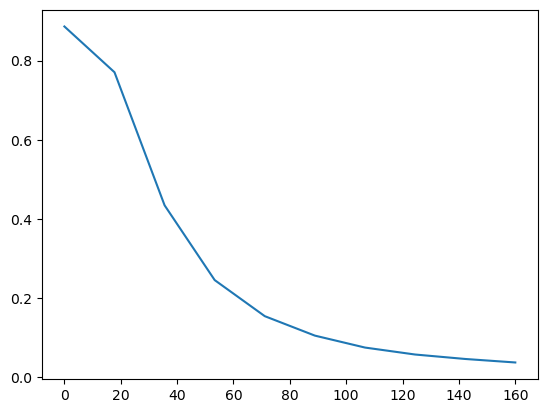

In [1207]:
Topt = popt[0]
ropt = popt[1]
#bopt = popt[2]
#copt = popt[3]
tlist2 = np.linspace(0,160,10)
tlist2, ret2 = drop_recap(tlist2,T=(Topt),base_retention=ropt, Tdepth = TFORT,
            progress=True, events = 20000)
print(ret2)

[  0.           8.42105263  16.84210526  25.26315789  33.68421053
  42.10526316  50.52631579  58.94736842  67.36842105  75.78947368
  84.21052632  92.63157895 101.05263158 109.47368421 117.89473684
 126.31578947 134.73684211 143.15789474 151.57894737 160.        ] [0.9      0.898785 0.83466  0.676935 0.52362  0.405315 0.318195 0.252315
 0.201825 0.16659  0.13923  0.116595 0.101205 0.089055 0.076815 0.06786
 0.060255 0.054    0.047745 0.042075]


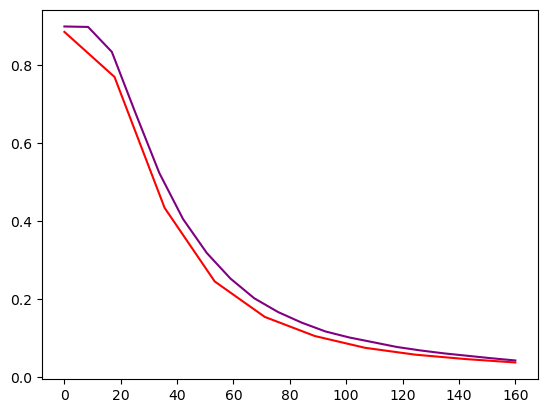

In [1208]:
#tlist3, ret3 = drop_recap(tlist, T=5, base_retention=0.9, Tdepth = TFORT, progress=True, events = event_ct)
plt.plot(tlist2, ret2, color = "red") # show time in units [us]
#plt.plot(tlist3*1e6,ret3, color = "purple") # show time in units [us]
plt.plot(tlist, r1, color = "purple") # show time in units [us]
print(tlist,r1)
plt.show()